# EJERCICIOS

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns

In [3]:
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

## EJERCICIO 1

¿Cuántas neuronas hacen falta en la capa de salida para clasificar emails entre correo no deseado y correo deseado? 

1 neurona, es una clasificación binaria

¿Qué función de activación deberías usar en la capa de salida? 

Sigmoide, para que sea entre 0 y 1

Si, en cambio, quieres enfrentarte a MNIST, ¿cuántas neuronas necesitas en la capa de salida y qué función de activación deberías usar? 
10, porque son del 0 al 9. Usaría softmax que usa probabilidades. 


¿Y si quieres que la red prediga los precios de la vivienda en California?
1 neurona, es un problema de regresión que devuelve un valor único y sin función 

## EJERCICIO 2

Entrena un red neuronal profunda con el conjunto de datos MNIST (puedes cargarlo con tf. keras. datasets.minst.load_data()). Intenta conseguir la mejor pruebas en el conjunto de validación  ajustando los hiperparámetros de modo manual. Prueba a buscar una buena tasa de aprendizaje y utiliza la detención temprana (mínimo hay que conseguir un 97%).

Pasos a seguir: 
+ Entrena varios modelos con distintas tasas de aprendizaje
+ Guarda cada modelo en un fichero
+ Carga cada modelo y evalúalo en el conjunto de cargas y quedate con programación con el mejor (bucle que se quede con el mejor), mostrando la tasa de aprendizaje y la exactitud del mejor modelo.

Si no obtienes más de un 97% vuelve a empezar.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train, x_test = x_train / 255.0, x_test / 255.0

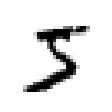

In [6]:
plt.figure(figsize=(1.2, 1.2))
plt.imshow(x_train[0], cmap="binary",interpolation="nearest")
plt.axis('off')
plt.show()

Hago una función para crear un modelo que recibe el learning rate

In [7]:
def crear_modelo(learning_rate):
    modelo = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    optimizador = Adam(learning_rate=learning_rate)
    
    modelo.compile(
        optimizer=optimizador,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return modelo


Pasarle a la función diferentes learning rates

In [8]:
tasas_aprendizaje = [0.001, 0.01, 0.1]
mejores_resultados = []

for lr in tasas_aprendizaje:
    modelo = crear_modelo(lr)
    
    # Entrenar modelo
    historia = modelo.fit(
        x_train, y_train, 
        validation_split=0.2,
        epochs=20,
        verbose=0
    )
    
    # Evaluar modelo
    perdida, exactitud = modelo.evaluate(x_test, y_test)
    
    # Guardar resultados
    mejores_resultados.append({
        'learning_rate': lr,
        'accuracy': exactitud
    })
    
    # Guardar modelo
    modelo.save(f'modelo_lr_{lr}.h5')


c:\Users\irune\OneDrive\Desktop\IABD\SAPA\SAPA\.conda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9739 - loss: 0.1492


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9574 - loss: 0.2793


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1160 - loss: 2.3169


Seleccionar mejor modelo

In [9]:
# Encontrar modelo con mayor exactitud
mejor_modelo = max(mejores_resultados, key=lambda x: x['accuracy'])

print(f"Mejor tasa de aprendizaje: {mejor_modelo['learning_rate']}")
print(f"Exactitud: {mejor_modelo['accuracy']}")

Mejor tasa de aprendizaje: 0.001
Exactitud: 0.9768999814987183


Si tiene > 97% OK, si no, volver a empezar

In [10]:
if mejor_modelo['accuracy'] < 0.97:
    print("No llega a el 97% de exactitud. Volver a empezar :(")
else:
    print("Llega a el 97% de exactitud. Yay! :)")


Llega a el 97% de exactitud. Yay! :)


## EJERCICIO 3

Clasificación de Imágenes de Dígitos Escritos a Mano:

* Objetivo: Entrenar una red neuronal para clasificar imágenes de dígitos escritos a mano utilizando el conjunto de datos SVHN (Street View House Numbers).

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos representando alguna imagen con su etiqueta y muestra los valores (únicos) de y (en el entrenamiento, en validación y en pruebas), preparar los datos (d normalizar dividiendo entre 255.0 e igual hay que hacer algo más), construir, compilar y entrenar una red neuronal. 

    * Utilizar detección temprana

    * Hacer una gráfica de como evoluciona accuracy y val_accuracy durante el entrenamiento

    * Si es necesario ajustar el modelo para lograr una mayor precisión.

    * Evalúar el modelo en el conjunto de test y hacer alguna predicción (representa alguna imagen con su etiqueta real y la predicha)

In [11]:
def load_svhn_data(url):
    path = tf.keras.utils.get_file("svhn.mat", url)
    data = loadmat(path)
    return np.transpose(data["X"], (3, 0, 1, 2)), data["y"].flatten()

# Cargar datos
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
X_train_full, y_train_full = load_svhn_data(train_url)
X_test, y_test = load_svhn_data(test_url)

In [12]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

def display_image(data, tag=""):
    plt.figure(figsize=(6, 6))
    plt.imshow(data)
    plt.axis('off') 
    if tag:
        plt.title(tag)
    plt.show()

def display_many(data, tags, rows, cols):
    # cuadrícula de imágenes
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i])
        ax.axis('off')
        ax.set_title(tags[i])

    plt.tight_layout()
    plt.show()

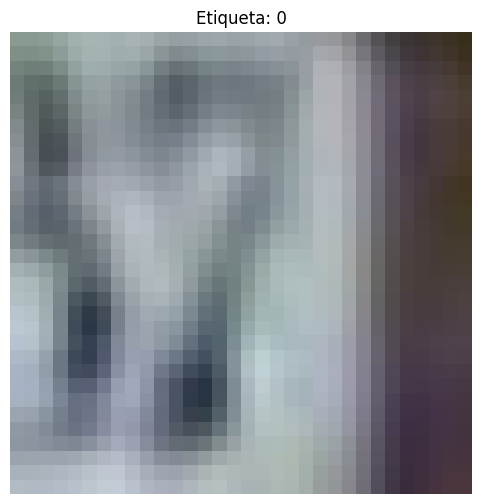

In [13]:
# Mostrar una imagen individual
display_image(X_train[0], f"Etiqueta: {np.argmax(y_train[0])}")




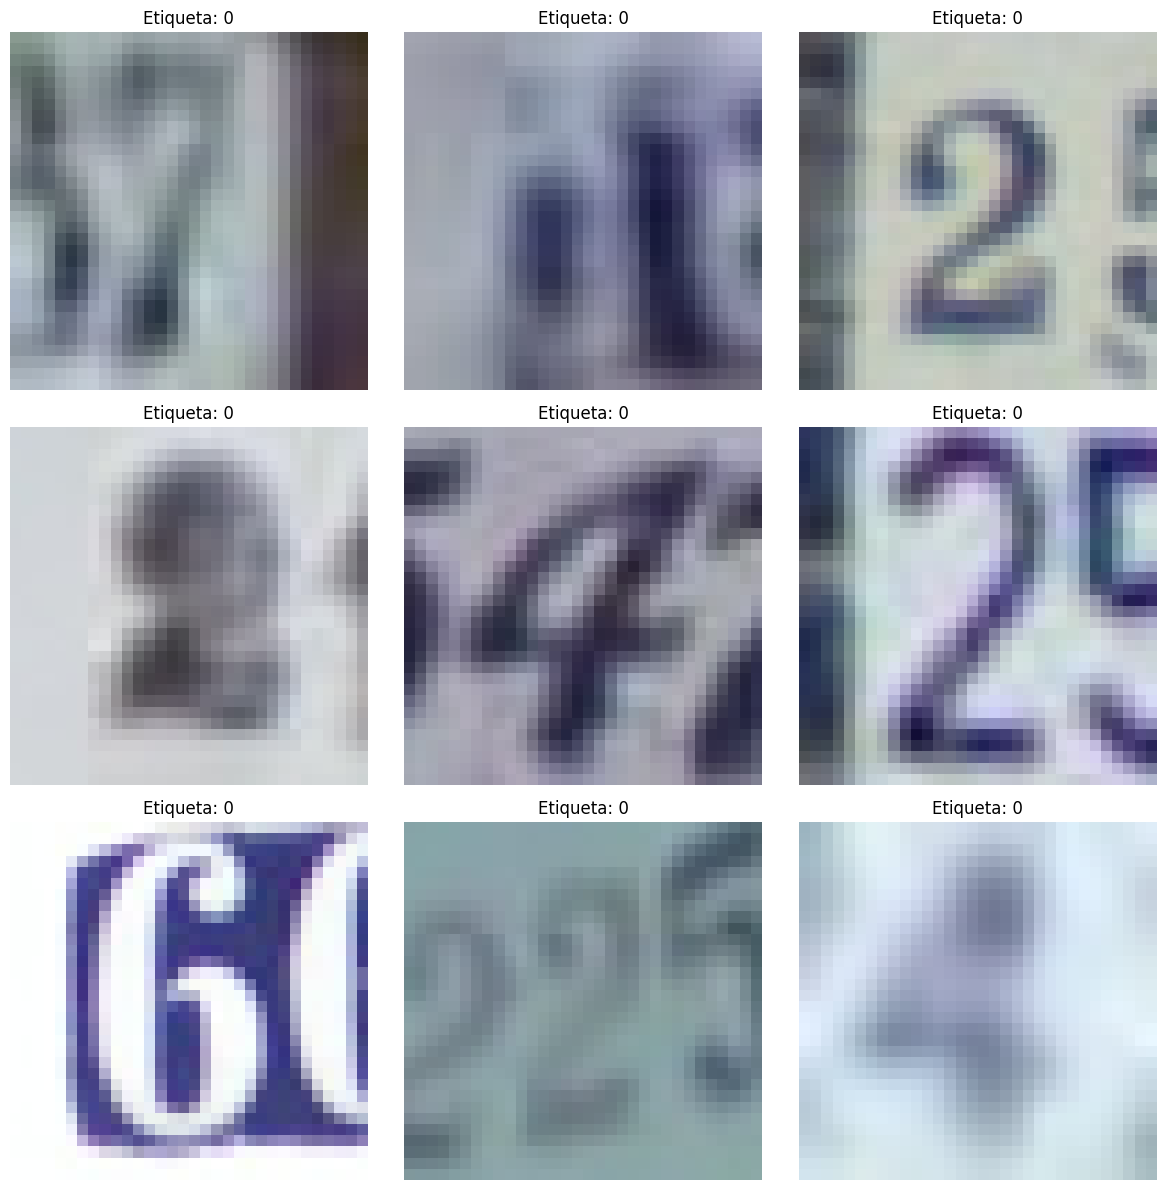

In [14]:
# Mostrar múltiples imágenes
display_many(X_train[:9], [f"Etiqueta: {np.argmax(y)}" for y in y_train[:9]], 3, 3)

In [19]:
valores, cuantos = np.unique(y_train, return_counts=True)
df = pd.DataFrame({
    'Valor': valores,
    'Cuantos': cuantos
})
print(df)

   Valor  Cuantos
0      0     3989
1      1    11015
2      2     8452
3      3     6807
4      4     6018
5      5     5505
6      6     4574
7      7     4472
8      8     4031
9      9     3742


In [20]:
# Normalizar los datos
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

print(X_train[0])

[[[0.00210688 0.00236832 0.00221453]
  [0.00210688 0.00236832 0.00222991]
  [0.00215302 0.00241446 0.00230681]
  ...
  [0.0009381  0.00079969 0.00067666]
  [0.00090734 0.00076894 0.00055363]
  [0.00084583 0.00070742 0.0004306 ]]

 [[0.00195309 0.00222991 0.00207612]
  [0.00192234 0.00219915 0.00206075]
  [0.00198385 0.00224529 0.00213764]
  ...
  [0.00099962 0.00084583 0.00078431]
  [0.00096886 0.00079969 0.00064591]
  [0.00090734 0.00073818 0.00047674]]

 [[0.00176855 0.00202999 0.00192234]
  [0.00169166 0.00195309 0.00184544]
  [0.00172241 0.00195309 0.0018762 ]
  ...
  [0.00107651 0.00092272 0.00090734]
  [0.00106113 0.00087659 0.00075356]
  [0.00099962 0.00079969 0.00058439]]

 ...

 [[0.0023837  0.00252211 0.00266052]
  [0.0023837  0.00253749 0.00267589]
  [0.0023837  0.00253749 0.00269127]
  ...
  [0.00103037 0.00076894 0.00101499]
  [0.00107651 0.00079969 0.00098424]
  [0.00109189 0.00078431 0.0009381 ]]

 [[0.00258362 0.00273741 0.00287582]
  [0.00258362 0.00273741 0.00287582]


Epoch 1/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 62s 64ms/step - accuracy: 0.4442 - loss: 1.6442 - val_accuracy: 0.6679 - val_loss: 0.9886
Epoch 2/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/step - accuracy: 0.8390 - loss: 0.5261 - val_accuracy: 0.5684 - val_loss: 1.3121
Epoch 3/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 60s 65ms/step - accuracy: 0.8715 - loss: 0.4224 - val_accuracy: 0.5585 - val_loss: 1.8027
Epoch 4/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 62s 68ms/step - accuracy: 0.8868 - loss: 0.3712 - val_accuracy: 0.7365 - val_loss: 0.8246
Epoch 5/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 59s 64ms/step - accuracy: 0.9005 - loss: 0.3317 - val_accuracy: 0.3857 - val_loss: 7.7929
Epoch 6/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 55s 60ms/step - accuracy: 0.9077 - loss: 0.2942 - val_accuracy: 0.2771 - val_loss: 3.9764
Epoch 7/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 58s 63ms/step - accuracy: 0.9182 - loss: 0.2696 - val_accuracy: 0.4816 - val_loss: 3.1828
Epoch 8/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 0.9200 - loss: 0

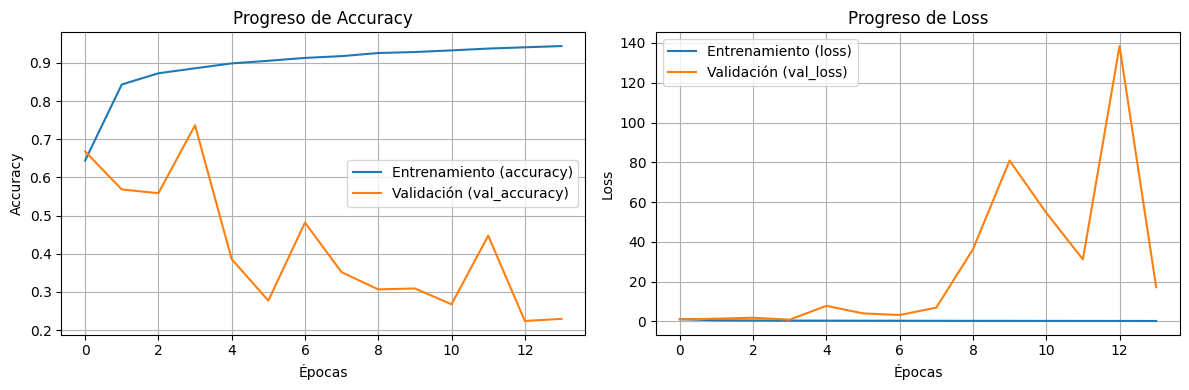

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Construir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "Checkpoints/svhn_model.weights.h5", 
    save_best_only=True,
    save_weights_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=10, 
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb],
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento (accuracy)')
plt.plot(history.history['val_accuracy'], label='Validación (val_accuracy)')
plt.title('Progreso de Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento (loss)')
plt.plot(history.history['val_loss'], label='Validación (val_loss)')
plt.title('Progreso de Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de test: {test_acc}")

2290/2290 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7469 - loss: 0.7728
Precisión en el conjunto de test: 0.7454987168312073


Índice seleccionado: 60739


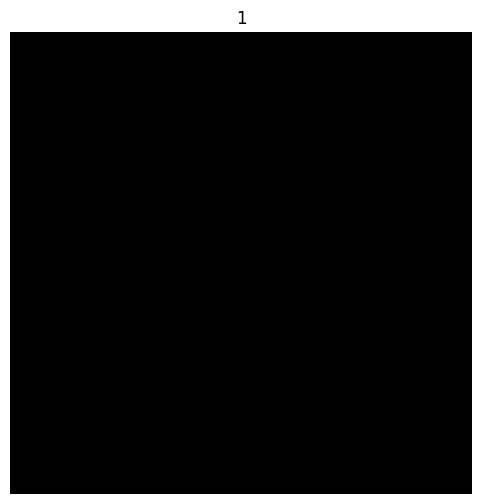

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicción de la clase: 1


In [26]:
# Selección aleatoria de un índice
indice_aleatorio = np.random.randint(0, len(X_test))
print(f"Índice seleccionado: {indice_aleatorio}")

# Mostrar la imagen
display_image(X_test[indice_aleatorio], y_test[indice_aleatorio])

# Realizar la predicción
prediccion = model.predict(np.expand_dims(X_test[indice_aleatorio], axis=0))  # Expandir dimensión para que sea (1, 32, 32, 3)

# Obtener la clase con la mayor probabilidad
prediccion_clase = np.argmax(prediccion, axis=1)

print(f"Predicción de la clase: {prediccion_clase[0]}")


## EJERCICIO 4

Predicción del consumo de energía:

* Objetivo: Construir una red neuronal para predecir el consumo de energía de edificios a partir de características como la temperatura, humedad, y tiempo del conjunto de datos Energy Efficiency de UCI Machine Learning Repository

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos, preparar los datos (normalizar con una capa de normalización), construir un modelo de regresión, compilar y entrenar una red neuronal. 
    
    * Usa X1-X8 para la X e Y1-Y2 para la y

    * Ajusta el modelo hasta encontrar un error absoluto medio aceptable

    * Haz una gráfica de como evoluciona el error absoluto medio y error absoluto medio del conjunto de validación durante el entrenamiento

    * Evalúa el modelo en el conjunto de test y haz alguna predicción (muestra el valor predicho y el real)

In [27]:
# Descargar el conjunto de datos de eficiencia energética de UCI
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")
data = pd.read_excel(url)

In [21]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [23]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


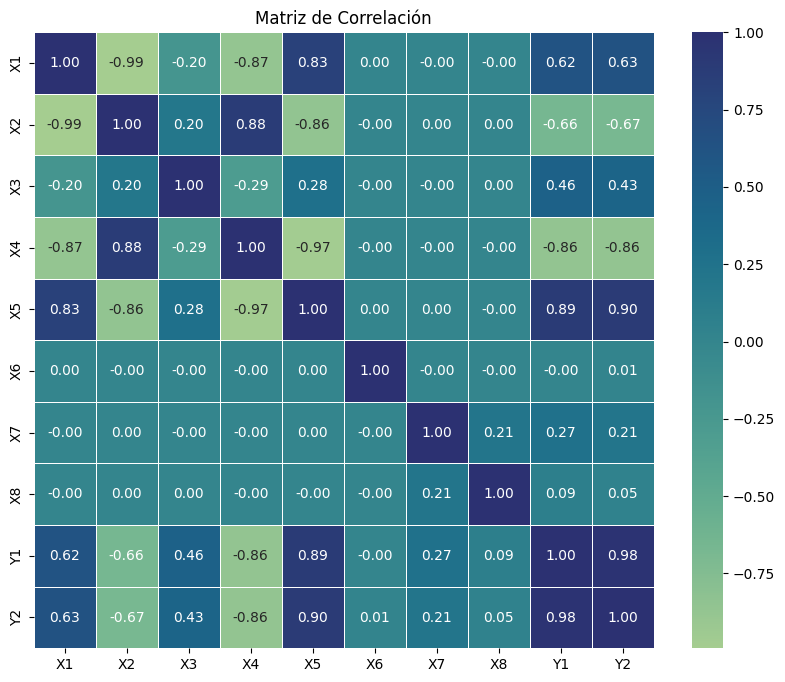

In [29]:
# Matriz de correlación
correlation_matrix = data.corr()

# Mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show() 

In [ ]:
# Las menos correlacionadas no me interesan
X = data[["X1", "X2", "X3", "X4", "X5", "X7"]]
y = data[["Y1", "Y2"]]
print(X.head())
print(y.head())

     X1     X2     X3      X4   X5   X7
0  0.98  514.5  294.0  110.25  7.0  0.0
1  0.98  514.5  294.0  110.25  7.0  0.0
2  0.98  514.5  294.0  110.25  7.0  0.0
3  0.98  514.5  294.0  110.25  7.0  0.0
4  0.90  563.5  318.5  122.50  7.0  0.0
      Y1     Y2
0  15.55  21.33
1  15.55  21.33
2  15.55  21.33
3  15.55  21.33
4  20.84  28.28


In [31]:
# Separar los datos
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Tamaño de validación: {X_valid.shape}, {y_valid.shape}")
print(f"Tamaño de prueba: {X_test.shape}, {y_test.shape}")

Tamaño de entrenamiento: (537, 6), (537, 2)
Tamaño de validación: (115, 6), (115, 2)
Tamaño de prueba: (116, 6), (116, 2)


In [37]:
# Crear una capa de normalización
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# Construir la red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2) # 2 salidas
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 6)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,751 (18.56 KB)

 Trainable params: 4,738 (18.51 KB)

 Non-trainable params: 13 (56.00 B)

In [48]:
# Entrenar el modelo
history = model.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7244 - mae: 1.7244 - val_loss: 1.6778 - val_mae: 1.6778
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5778 - mae: 1.5778 - val_loss: 1.8752 - val_mae: 1.8752
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7892 - mae: 1.7892 - val_loss: 1.6844 - val_mae: 1.6844
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6462 - mae: 1.6462 - val_loss: 1.6832 - val_mae: 1.6832
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5168 - mae: 1.5168 - val_loss: 1.5644 - val_mae: 1.5644
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4723 - mae: 1.4723 - val_loss: 1.5423 - val_mae: 1.5423
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6003 - mae: 1.6003 - val_loss: 1.7764 - val_mae: 1.7764
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5754 - mae: 1.5754 - val_loss: 1.6301 - val_mae: 1.6301
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.466

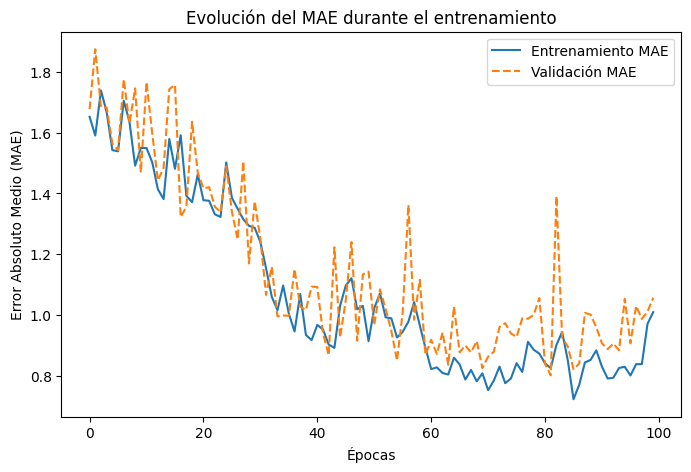

In [49]:
# MAE
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Entrenamiento MAE')
plt.plot(history.history['val_mae'], label='Validación MAE', linestyle='dashed')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.legend()
plt.title('Evolución del MAE durante el entrenamiento')
plt.show()

In [51]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"\nEvaluación en test: MAE = {test_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9592 - mae: 0.9592 

Evaluación en test: MAE = 0.9477


In [52]:
# Hacer predicciones con el modelo entrenado
y_test = np.array(y_test)
predictions = model.predict(X_test[:5])  # Predecir las primeras 5 muestras

for i in range(5):
    print(f"Real      : {np.round(y_test[i], 3)}")
    print(f"Predicción: {np.round(predictions[i], 3)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real      : [24.94 29.88]
Predicción: [26.004 28.355]
Real      : [35.45 41.86]
Predicción: [35.899 38.774]
Real      : [28.07 34.14]
Predicción: [29.221 32.299]
Real      : [ 8.6  12.07]
Predicción: [ 8.896 12.369]
Real      : [36.95 36.87]
Predicción: [35.421 36.326]



Entrenando con learning rate: 0.003
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.7378 - mae: 22.7378 - val_loss: 20.7856 - val_mae: 20.7856
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.1671 - mae: 16.1671 - val_loss: 9.9456 - val_mae: 9.9456
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3337 - mae: 7.3337 - val_loss: 5.7361 - val_mae: 5.7361
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9975 - mae: 3.9975 - val_loss: 4.1675 - val_mae: 4.1675
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5250 - mae: 3.5250 - val_loss: 3.7842 - val_mae: 3.7842
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0712 - mae: 3.0712 - val_loss: 3.4350 - val_mae: 3.4350
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7188 - mae: 2.7188 - val_loss: 3.1452 - val_mae: 3.1452
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5807 - mae: 2.5807 - val_loss: 2.8419 - val_mae: 2.8419
Epoch 9/100
17/17 ━━━

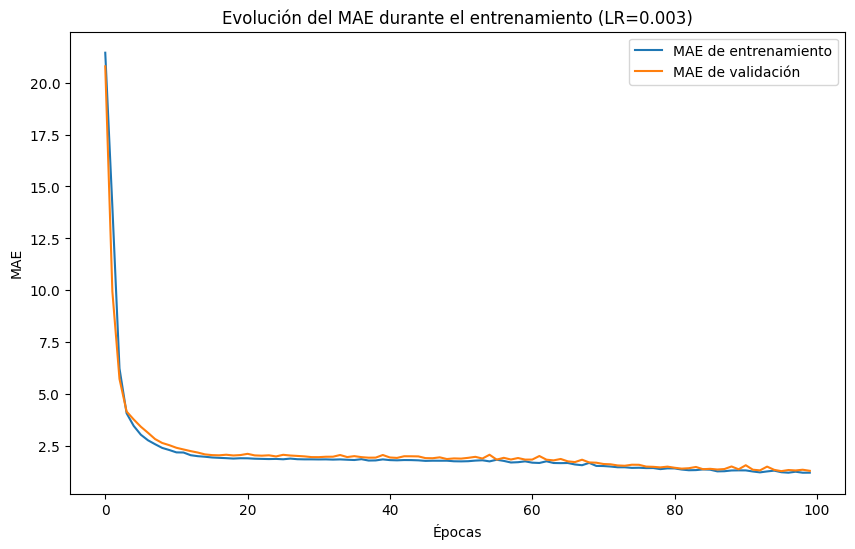

MAE en el conjunto de prueba: 1.12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Real: [24.94 29.88]
Predicción: [33.398 32.336]
Diferencia: [8.458 2.456]
Real: [35.45 41.86]
Predicción: [34.593 34.436]
Diferencia: [-0.857 -7.424]
Real: [28.07 34.14]
Predicción: [28.482 29.564]
Diferencia: [ 0.412 -4.576]
Real: [ 8.6  12.07]
Predicción: [ 8.138 11.55 ]
Diferencia: [-0.462 -0.52 ]
Real: [36.95 36.87]
Predicción: [36.741 36.628]
Diferencia: [-0.209 -0.242]
Promedio de la diferencia absoluta (Y1, Y2): [0.82664811 1.41404578]

Entrenando con learning rate: 0.005
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 22.3053 - mae: 22.3053 - val_loss: 17.3877 - val_mae: 17.3877
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0968 - mae: 11.0968 - val_loss: 6.3890 - val_mae: 6.3890
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1869 - mae: 5.1869 - val_loss: 4.4568 - val_mae: 4.4568
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7104 - mae: 3.7104 - val

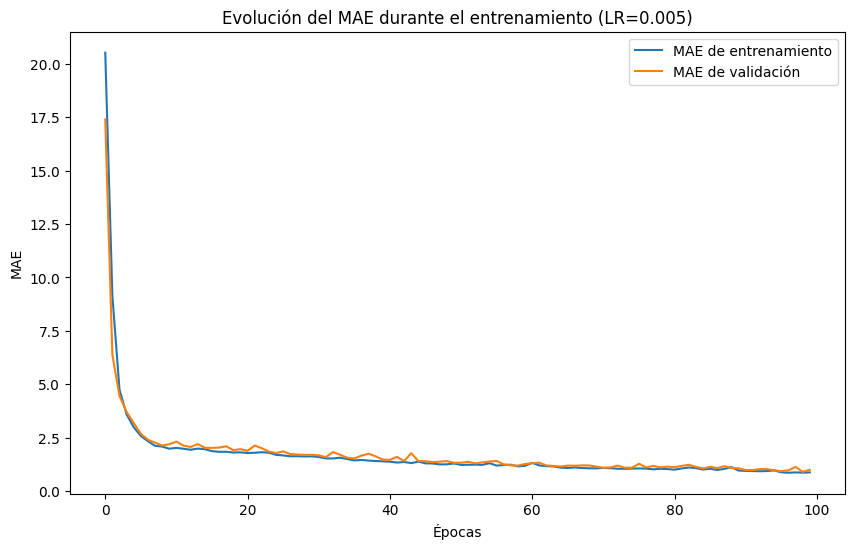

MAE en el conjunto de prueba: 0.97
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Real: [24.94 29.88]
Predicción: [27.331 28.842]
Diferencia: [ 2.391 -1.038]
Real: [35.45 41.86]
Predicción: [35.214 36.88 ]
Diferencia: [-0.236 -4.98 ]
Real: [28.07 34.14]
Predicción: [27.349 29.209]
Diferencia: [-0.721 -4.931]
Real: [ 8.6  12.07]
Predicción: [10.343 12.674]
Diferencia: [1.743 0.604]
Real: [36.95 36.87]
Predicción: [36.06  36.648]
Diferencia: [-0.89  -0.222]
Promedio de la diferencia absoluta (Y1, Y2): [0.71857973 1.21376763]

Entrenando con learning rate: 0.007
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21.1888 - mae: 21.1888 - val_loss: 10.6070 - val_mae: 10.6070
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2767 - mae: 7.2767 - val_loss: 5.2010 - val_mae: 5.2010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1631 - mae: 4.1631 - val_loss: 3.7845 - val_mae: 3.7845
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1942 - mae: 3.1942 - val_lo

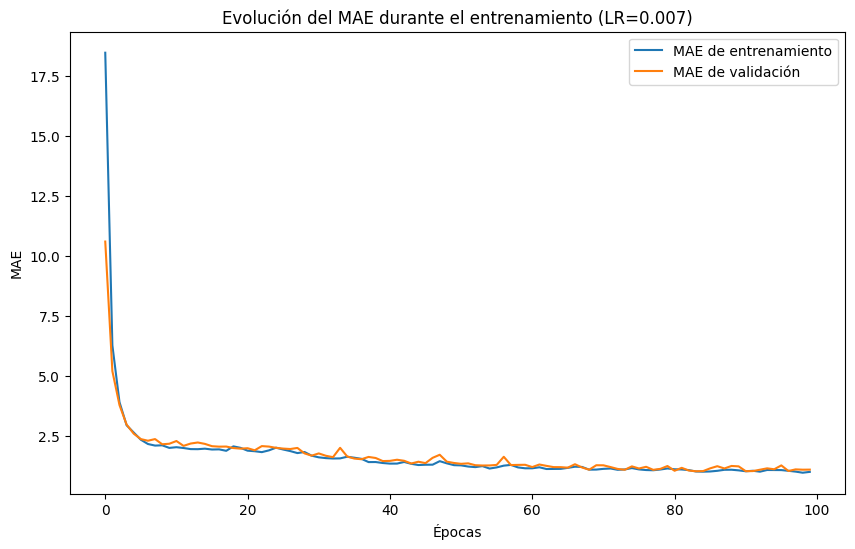

MAE en el conjunto de prueba: 0.98
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Real: [24.94 29.88]
Predicción: [30.271 29.876]
Diferencia: [ 5.331e+00 -4.000e-03]
Real: [35.45 41.86]
Predicción: [36.587 38.11 ]
Diferencia: [ 1.137 -3.75 ]
Real: [28.07 34.14]
Predicción: [28.79  29.907]
Diferencia: [ 0.72  -4.233]
Real: [ 8.6  12.07]
Predicción: [ 7.916 11.652]
Diferencia: [-0.684 -0.418]
Real: [36.95 36.87]
Predicción: [37.783 37.39 ]
Diferencia: [0.833 0.52 ]
Promedio de la diferencia absoluta (Y1, Y2): [0.73745855 1.22055169]

Entrenando con learning rate: 0.01
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.9961 - mae: 20.9961 - val_loss: 6.6576 - val_mae: 6.6576
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0673 - mae: 5.0673 - val_loss: 4.2196 - val_mae: 4.2196
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9081 - mae: 3.9081 - val_loss: 3.3597 - val_mae: 3.3597
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9123 - mae: 2.9123 - v

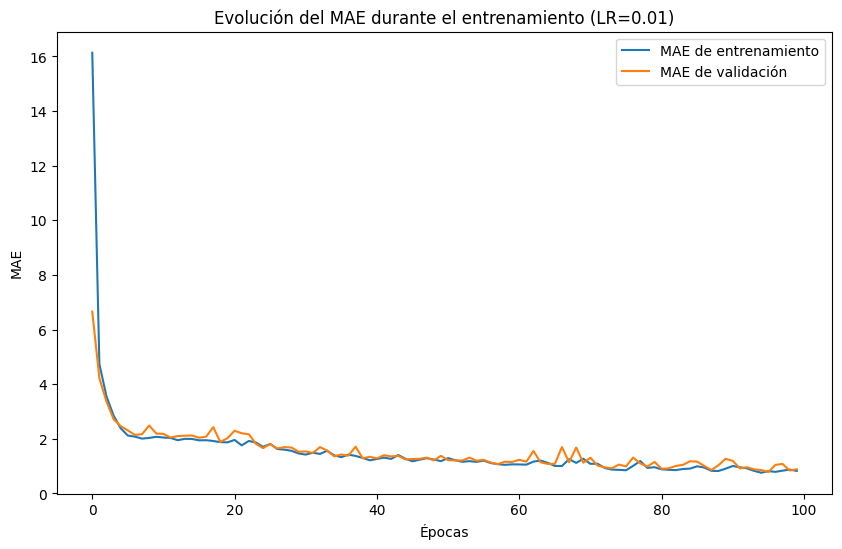

MAE en el conjunto de prueba: 0.84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Real: [24.94 29.88]
Predicción: [26.428 28.264]
Diferencia: [ 1.488 -1.616]
Real: [35.45 41.86]
Predicción: [36.246 37.215]
Diferencia: [ 0.796 -4.645]
Real: [28.07 34.14]
Predicción: [28.981 30.907]
Diferencia: [ 0.911 -3.233]
Real: [ 8.6  12.07]
Predicción: [ 9.233 13.032]
Diferencia: [0.633 0.962]
Real: [36.95 36.87]
Predicción: [36.414 37.336]
Diferencia: [-0.536  0.466]
Promedio de la diferencia absoluta (Y1, Y2): [0.47453781 1.20042731]

Entrenando con learning rate: 0.05
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.7139 - mae: 13.7139 - val_loss: 5.9639 - val_mae: 5.9639
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0496 - mae: 4.0496 - val_loss: 3.8893 - val_mae: 3.8893
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8954 - mae: 3.8954 - val_loss: 2.7308 - val_mae: 2.7308
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5687 - mae: 2.5687 - val_loss:

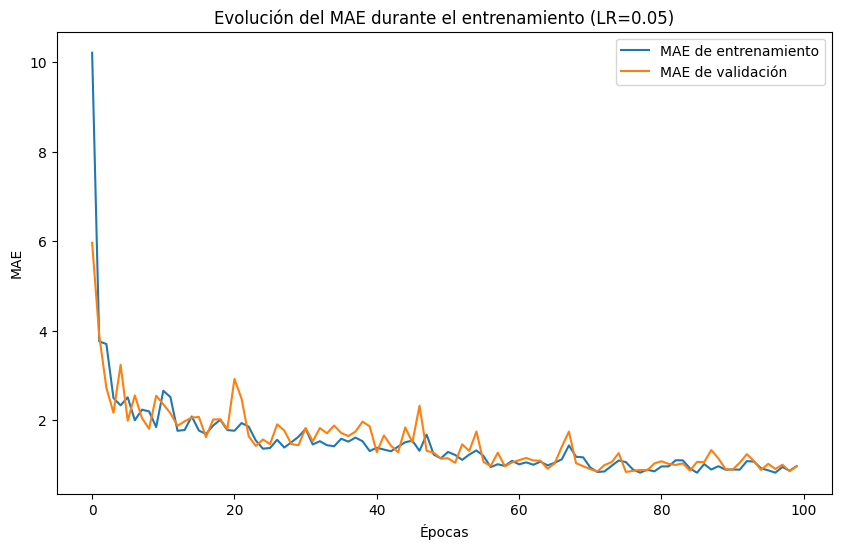

MAE en el conjunto de prueba: 0.87
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Real: [24.94 29.88]
Predicción: [26.42  27.326]
Diferencia: [ 1.48  -2.554]
Real: [35.45 41.86]
Predicción: [37.99  37.336]
Diferencia: [ 2.54  -4.524]
Real: [28.07 34.14]
Predicción: [29.694 30.787]
Diferencia: [ 1.624 -3.353]
Real: [ 8.6  12.07]
Predicción: [ 9.132 12.485]
Diferencia: [0.532 0.415]
Real: [36.95 36.87]
Predicción: [36.226 35.183]
Diferencia: [-0.724 -1.687]
Promedio de la diferencia absoluta (Y1, Y2): [0.57120171 1.17525341]

Entrenando con learning rate: 0.1
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 13.6350 - mae: 13.6350 - val_loss: 3.8979 - val_mae: 3.8979
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5853 - mae: 3.5853 - val_loss: 1.9325 - val_mae: 1.9325
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2857 - mae: 2.2857 - val_loss: 2.1038 - val_mae: 2.1038
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5038 - mae: 2.5038 - val_loss:

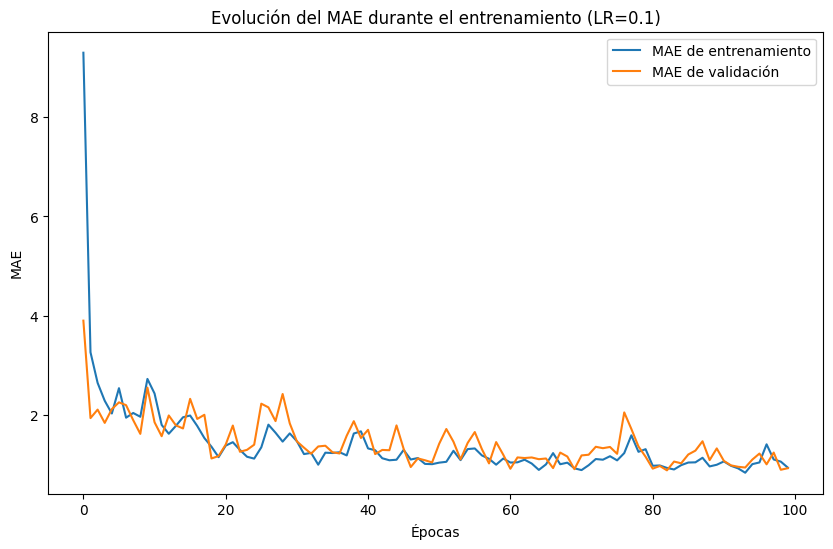

MAE en el conjunto de prueba: 0.85
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Real: [24.94 29.88]
Predicción: [26.183 26.798]
Diferencia: [ 1.243 -3.082]
Real: [35.45 41.86]
Predicción: [36.133 37.74 ]
Diferencia: [ 0.683 -4.12 ]
Real: [28.07 34.14]
Predicción: [28.865 30.214]
Diferencia: [ 0.795 -3.926]
Real: [ 8.6  12.07]
Predicción: [ 8.067 12.001]
Diferencia: [-0.533 -0.069]
Real: [36.95 36.87]
Predicción: [36.603 36.025]
Diferencia: [-0.347 -0.845]
Promedio de la diferencia absoluta (Y1, Y2): [0.45983829 1.2482257 ]


In [55]:

# Lista de learning rates a probar
learning_rates = [0.003, 0.005, 0.007, 0.01, 0.05, 0.1]

# Diccionario para guardar los históricos
history_dict = {}

# Entrenar modelos con diferentes learning rates
for learning_rate in learning_rates:
    print(f"\nEntrenando con learning rate: {learning_rate}")

    # Construir la red neuronal
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        normalizer,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)  # 2 salidas
    ])

    # Compilar el modelo con el learning rate actual
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mae', metrics=['mae'])

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=100,
        batch_size=32,
        verbose=1
    )

    # Guardar el historial
    history_dict[learning_rate] = history

    # Graficar la evolución del error absoluto medio (MAE)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='MAE de entrenamiento')
    plt.plot(history.history['val_mae'], label='MAE de validación')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.title(f'Evolución del MAE durante el entrenamiento (LR={learning_rate})')
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"MAE en el conjunto de prueba: {test_mae:.2f}")

    # Realizar predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Mostrar algunas predicciones junto con sus valores reales
    for i in range(5):
        print(f"Real: {np.round(y_test[i], 3)}")
        print(f"Predicción: {np.round(predictions[i], 3)}")
        print(f"Diferencia: {np.round(predictions[i] - y_test[i], 3)}")

    # Calcular el promedio de la diferencia entre predicciones y valores reales
    differences = np.abs(predictions - y_test)  # Diferencias absolutas
    average_difference = np.mean(differences, axis=0)  # Promedio por columna
    print(f"Promedio de la diferencia absoluta (Y1, Y2): {average_difference}")


0.01 es el que mejor resultado me da